# Experimental Roman Extraction 1.2-134-g45befdc

A few notes from the simulation from Anahita:

- H158 filter curve: attached
- Mag limit of the simulation : 28AB magnitude (in H158)
- Exposure time : direct_image_Exptime=141sec, dispersed_image_Exptime=301sec
- Number of exposures combined: just 1 exposure with the given exptimes as above
- Number of roll angles (I would imagine we would have multiple roll angles for the HLS): We will have 4 roll angles , and 2 dithers at each roll angle. These images should be angle=0. Buteventually we will produce products at roll angles=0,5,170 &175 (as suggested by Jeff Kruk and Yun)
- What are the artifacts in the direct images (CRs, diffraction spikes, bad or hot pixels)? I am no including any CRs in the direct images. Diffractions spikes are present for stars because we use PSF as the image profiles for our stars. I do not think that bad and/or hot pixels are included either (will double check).

In [1]:
%matplotlib inline

## Import Python modules

In [2]:
import os,sys
from collections import OrderedDict

import matplotlib as mpl    
import matplotlib.pyplot as plt    
import matplotlib.gridspec
mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.dpi'] = 72

import numpy as np
from math import cos, sin, atan2, pi

import astropy
import astropy.io.fits as pyfits
import astropy.wcs as pywcs
from astropy.table import Table

import drizzlepac
import photutils

import grizli
import grizli.model
import grizli.multifit
import grizli.fake_image
from grizli.pipeline import auto_script
from grizli import prep

print('\n Python version: ', sys.version)
print('\n Grizli version: ', grizli.__version__)
print('\n Astropy version: ', astropy.__version__)



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol

 Python version:  3.6.13 |Anaconda, Inc.| (default, Feb 23 2021, 12:58:59) 
[GCC Clang 10.0.0 ]

 Grizli version:  1.3.2

 Astropy version:  4.0.2


## Python Helper Functions

In [3]:
def wcs_pixel_scale(file,ext=1):

    hdu = pyfits.open(file)
    hdu.info()
    head = hdu[ext].header

    naxis2 = head["NAXIS2"]
    crpix1 = head["CRPIX1"]
    crpix2 = head["CRPIX2"]
    crval1 = head["CRVAL1"]
    crval2 = head["CRVAL2"]
    ctype1 = head["CTYPE1"]
    ctype2 = head["CTYPE2"]
    
    cd1_1 = head["CD1_1"]
    cd1_2 = head["CD1_2"]
    cd2_1 = head["CD2_1"]
    cd2_2 = head["CD2_2"]
    
    crota1 = atan2( cd2_1, cd1_1)  # radians
    crota2 = atan2(-cd1_2, cd2_2)  # radians
    cdelt1 = cd1_1/cos(crota1)     # deg/pix
    cdelt2 = cd2_2/cos(crota1)     # deg/pix

    print('cdelt1 = %.4f "/pixel' % (cdelt1*3600))
    print('cdelt2 = %.4f "/pixel' % (cdelt2*3600))
    print('crota1 = %.4f deg' % (crota1*180/pi))
    print('crota2 = %.4f deg' % (crota2*180/pi))
    print()

In [4]:
def create_circular_mask(h, w, center, radius):

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [5]:
def check_sims(sim, mag_limit):
    
    mask = sim.catalog['MAG_AUTO'] < mag_limit
    
    all_cat = sim.catalog
    magcut_cat = sim.catalog[mask]

    new_ids = []
    for id in sim.object_dispersers:
        is_cgs, spectrum_1d, beam = sim.object_dispersers[id]
        if len(beam) > 0: 
            new_ids.append(id)
        
    new_ids = np.array(new_ids)
    #print(new_ids)
        
    extract_cat = sim.catalog[new_ids - 1] 
    
    print("All sources   =",len(all_cat))
    print("Magnitude cut =",len(magcut_cat))
    print("Simulated     =",len(new_ids))
    print()
    #print(len(extract_cat))
    
    return all_cat,magcut_cat,extract_cat

## Synphot files (SKIP)

They seem to be only needed for multimission during the extraction. It is likely they will not be needed eventually in this Jupoyter notebook.

They can be downloaded here: https://archive.stsci.edu/hlsp/reference-atlases

In [ ]:
import os
os.environ["PYSYN_CDBS"] = "/Volumes/data5/d2/data/JWST/grp/hst/cdbs/"
print(os.environ["PYSYN_CDBS"])

In [ ]:
print(os.getcwd())

## Path to Anihita's simulation directories

In [6]:
os.chdir('../Roman')
HOME_PATH = os.getcwd()
print('HOME_PATH = ', HOME_PATH)
#root = "new_simulation_old"
root = "new_simulation"      # Most recent sims, scale incorrect, objects look more realistic

HOME_PATH =  /Users/gwalth/data/Roman/grizli/Roman


## Directory Structure

I was structing it similar to Grizli with Prep, RAW and Extraction directories.  If this were real mission data, the stage that we recieved from Anihita would have been drizzled images and spectra which would go into the Prep directories.

This is just showing that we have the right directories and we can find all of the files.

In [7]:
import glob

os.chdir(os.path.join(HOME_PATH, root, 'Prep'))
direct_files = glob.glob('*direct.fits')
slitless_files = glob.glob('*slitless.fits')
direct_files.sort()
slitless_files.sort()
print(direct_files)
print(slitless_files)

['GRS_FOV1_roll0_dx0_dy0_SCA1_direct.fits']
['GRS_FOV1_roll0_dx0_dy0_SCA1_slitless.fits']


## Single Roman Detector

As a test until everything is up and running I am just using SCA1.

In [8]:
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

direct_files = ['GRS_FOV1_roll0_dx0_dy0_SCA1_direct.fits']
slitless_files = ['GRS_FOV1_roll0_dx0_dy0_SCA1_slitless.fits']

## Find sources in the direct image

Just like the multi-mission, I am using SExtractor to find all of the sources in the direct images. This step is important not only for finding the sources but also for generating the segmentation map which will be used during the extraction of the spectra.

I may eventually adapt this to use SEP just like Grizli, but currently I understand SExtractor a little better.

The re-run the previous step, run this command.  In case you want to change the SExtractor parameters.

In [9]:
# remove segmentation FITS to redo "next" step
!rm *_seg.fits

In [10]:
## Make SExtractor catalog

for direct in direct_files:

    prefix = direct.replace(".fits","")
             
    cat = prefix + ".cat"   
    seg = prefix + "_seg.fits"
    bkg = prefix + "_bkg.fits"
    #aper = prefix + "_aper.fits"
    
    if not os.path.exists('GRS_FOV1_roll0_dx0_dy0_SCA1_direct_seg.fits'):
        #os.system('wget http://www.stsci.edu/~brammer/grism/grizli_xdf_sextractor.tar.gz')
        #os.system('tar xzvf grizli_xdf_sextractor.tar.gz')
        
        sex = prefix + ".sex"
        
        wht = direct + "[2]"
        direct_ext = direct + "[1]"
        
        checkimage_name = seg + "," + bkg
        #checkimage_name = seg + "," + bkg + "," + aper
        
        sex_str = 'sex ' + direct_ext + ' -c ' + sex + ' -WEIGHT_IMAGE ' + wht + \
                  ' -CHECKIMAGE_NAME ' + checkimage_name + ' -CATALOG_NAME ' + cat 
        os.system(sex_str)
        print(sex_str)

        #os.system('sex hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits ' + 
        #          '-c hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1.sex')
        

# awk '{ printf "circle(%f, %f, 0.00007) # text={%.3f}\n", $4, $5, $42 }' GRS_FOV1_roll0_dx0_dy0_SCA1_direct.cat > GRS_FOV1_roll0_dx0_dy0_SCA1_direct.reg
        

sex GRS_FOV1_roll0_dx0_dy0_SCA1_direct.fits[1] -c GRS_FOV1_roll0_dx0_dy0_SCA1_direct.sex -WEIGHT_IMAGE GRS_FOV1_roll0_dx0_dy0_SCA1_direct.fits[2] -CHECKIMAGE_NAME GRS_FOV1_roll0_dx0_dy0_SCA1_direct_seg.fits,GRS_FOV1_roll0_dx0_dy0_SCA1_direct_bkg.fits -CATALOG_NAME GRS_FOV1_roll0_dx0_dy0_SCA1_direct.cat


This a temporary. Around here is where I would loop over all of the detectors. 

In [11]:
direct = direct_files[0]
slitless = slitless_files[0]
print(direct)
print(slitless)

GRS_FOV1_roll0_dx0_dy0_SCA1_direct.fits
GRS_FOV1_roll0_dx0_dy0_SCA1_slitless.fits


## Updating headers for Grizli

Grizli looks for specific headers in order to decide with instrument conf file to use.  This also needed for how to scale the photometry and spectrocopy throughput.  

This is also useful for testing multiple conf files (which appears to be the case we are now in).

In [12]:
# modify header to make grizli happy
new_direct = direct.replace(".fits","_GLW.fits")
new_slitless = slitless.replace(".fits","_GLW.fits")


#ext = 0
hdu = pyfits.open(direct)
hdu.info()
#del hdu[ext].header['']

ext = 0
hdu[ext].header['FILTER'] = 'H158'
hdu[ext].header['INSTRUME'] = 'ROMANv1' # conf version that works with both sims
#hdu[ext].header['INSTRUME'] = 'ROMANv2' # conf version that has the correct scale

ext = 1
hdu[ext].header['FILTER'] = 'H158'
hdu[ext].header['INSTRUME'] = 'ROMANv1'
#hdu[ext].header['INSTRUME'] = 'ROMANv2'
hdu.writeto(new_direct,clobber=True)


ext = 0
hdu = pyfits.open(slitless)
hdu.info()
#hdu[ext].header['FILTER'] = 'H158'
hdu[ext].header['INSTRUME'] = 'ROMANv1'
#hdu[ext].header['INSTRUME'] = 'ROMANv2'
hdu[ext].header['FILTER'] = 'GRISM'
hdu.writeto(new_slitless,clobber=True)


# jdga30joq_flc.fits
# ext = 0
#TELESCOP= 'HST'                / telescope used to acquire data                 
#INSTRUME= 'ACS   ' 

Filename: GRS_FOV1_roll0_dx0_dy0_SCA1_direct.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4088, 4088)   float32   
  2  ERR           1 ImageHDU        71   (4088, 4088)   float32   
  3  DQ            1 ImageHDU        35   (4088, 4088)   int32   
Filename: GRS_FOV1_roll0_dx0_dy0_SCA1_slitless.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4088, 4088)   float32   
  2  ERR           1 ImageHDU        71   (4088, 4088)   float32   
  3  DQ            1 ImageHDU        35   (4088, 4088)   int32   


In [ ]:
############################
# EXPERIMENTAL (DON'T USE) #
############################

# modify header to make grizli happy
new_direct = direct.replace(".fits","_drz_sci.fits")
new_slitless = slitless.replace(".fits","_drz_sci.fits")


hdu = pyfits.open(direct)
hdu.info()

for h in hdu:
    head = h.header
    if 'EXTNAME' in head and head['EXTNAME'] in ['SCI','ERR']:
        img = h.data
        print(head['EXTNAME'])
        head['FILTER'] = 'H158'
        head['INSTRUME'] = 'ROMAN'
        
        hdu = pyfits.PrimaryHDU(img,header=head)
        #hdu.verify('warn')''
        if head['EXTNAME'] == 'ERR': nf = new_direct.replace("_sci.fits","_wht.fits")
        else: nf = new_direct
        hdu.writeto(nf,clobber=True)

        
hdu = pyfits.open(slitless)
hdu.info()

for h in hdu:
    head = h.header
    if 'EXTNAME' in head and head['EXTNAME'] in ['SCI','ERR']:
        img = h.data
        print(head['EXTNAME'])
        head['FILTER'] = 'GRISM'
        head['INSTRUME'] = 'ROMAN'
        
        hdu = pyfits.PrimaryHDU(img,header=head)
        #hdu.verify('warn')''
        if head['EXTNAME'] == 'ERR': nf = new_slitless.replace("_sci.fits","_wht.fits")
        else: nf = new_slitless
        hdu.writeto(nf,clobber=True)


# jdga30joq_flc.fits
# ext = 0
#TELESCOP= 'HST'                / telescope used to acquire data                 
#INSTRUME= 'ACS   ' 

## (TESTING) Working with pipeline parameters and SEP - SKIP


Grizli versions `>0.10.0` provide an interface for reading pipeline parameters from a YAML ascii file.  All of the parameter defaults are stored in a file in the repository `grizli/data/auto_script_defaults.yml`.  You can edit copies of this file to generate a reproducible history of the pipeline processing.

In [ ]:
from grizli.pipeline.auto_script import get_yml_parameters

# Read the default parameters that can be edited and passed en-masse to `auto_script.go`
kwargs = get_yml_parameters()
print(list(kwargs.keys()))

In [ ]:
# Copy default parameters to working directory
default_kwargs = get_yml_parameters(local_file='my_params.yml', copy_defaults=True)

print('\n ---- my_params.yml ---\n')
!head -13 my_params.yml
print('    ...')

In [ ]:
# Perhaps edit the parameter file by hand, then read it in.
# Or just edit the "default_kwargs" dictionary directly and pass that
kwargs = get_yml_parameters(local_file='my_params.yml', copy_defaults=False)

In [ ]:
print(kwargs['multiband_catalog_args'])

multiband_catalog_args = kwargs['multiband_catalog_args']

In [ ]:
prefix1 = new_direct.replace("_drz_sci.fits","-")
phot1 = prep.make_SEP_catalog(root=prefix, sci=new_direct, **multiband_catalog_args)

# Continue Grism Pipeline

## Check the pixel scale of the images

In [13]:
wcs_pixel_scale(direct)
wcs_pixel_scale(slitless)

Filename: GRS_FOV1_roll0_dx0_dy0_SCA1_direct.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4088, 4088)   float32   
  2  ERR           1 ImageHDU        71   (4088, 4088)   float32   
  3  DQ            1 ImageHDU        35   (4088, 4088)   int32   
cdelt1 = 0.0284 "/pixel
cdelt2 = -0.0226 "/pixel
crota1 = 40.1589 deg
crota2 = -134.0613 deg

Filename: GRS_FOV1_roll0_dx0_dy0_SCA1_slitless.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4088, 4088)   float32   
  2  ERR           1 ImageHDU        71   (4088, 4088)   float32   
  3  DQ            1 ImageHDU        35   (4088, 4088)   int32   
cdelt1 = 0.0284 "/pixel
cdelt2 = -0.0226 "/pixel
crota1 = 40.1589 deg
crota2 = -134.0613 deg



## Read SExtractor Photometry of Direct Images

In [14]:
print(cat)
phot = Table.read(cat, format='ascii.sextractor') # ref_cat in multimission

GRS_FOV1_roll0_dx0_dy0_SCA1_direct.cat


In [15]:
phot[:10].show_in_notebook()

idx,NUMBER,X_IMAGE,Y_IMAGE,X_WORLD,Y_WORLD,A_IMAGE,B_IMAGE,THETA_IMAGE,A_WORLD,B_WORLD,THETA_WORLD,FLUX_APER,FLUX_APER_1,FLUX_APER_2,FLUX_APER_3,FLUX_APER_4,FLUX_APER_5,FLUX_APER_6,FLUX_APER_7,FLUX_APER_8,FLUX_APER_9,FLUX_APER_10,FLUX_APER_11,FLUX_APER_12,FLUX_APER_13,FLUXERR_APER,FLUXERR_APER_1,FLUXERR_APER_2,FLUXERR_APER_3,FLUXERR_APER_4,FLUXERR_APER_5,FLUXERR_APER_6,FLUXERR_APER_7,FLUXERR_APER_8,FLUXERR_APER_9,FLUXERR_APER_10,FLUXERR_APER_11,FLUXERR_APER_12,FLUXERR_APER_13,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,MAG_BEST,MAGERR_BEST,KRON_RADIUS,PETRO_RADIUS,BACKGROUND,THRESHOLD,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,ERRA_WORLD,ERRB_WORLD,ERRTHETA_WORLD,XWIN_IMAGE,YWIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,THETAWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,MU_THRESHOLD,FLAGS,FWHM_IMAGE,FLUX_RADIUS,FLUX_RADIUS_1,CLASS_STAR
,,pix,pix,deg,deg,pix,pix,deg,deg,deg,deg,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,mag,mag,mag,mag,,,ct,ct,pix,pix,deg,deg,deg,deg,pix,pix,pix,pix,deg,pix,pix,deg,mag / arcsec2,,pix,pix,pix,
0,1,3376.4963,73.9929,53.242008498,-27.806804338,2.036,1.478,-87.21,1.413582e-05,1.155242e-05,-34.28,4.751146,6.426812,6.877778,7.127317,7.668445,8.032232,8.183122,8.262062,8.650845,9.921555,14.10507,21.64993,47.35143,138.6724,2.190872,2.550728,2.643346,2.696637,2.803243,2.87649,2.912416,2.937025,3.014983,3.292414,3.964055,5.01975,7.557043,13.28599,8.34911,2.929961,25.6959,0.3811,25.577,0.3396,3.3,3.5,0.2437829,0.07277536,0.85422,0.61993,-87.18,5.929935e-06,4.846604e-06,-34.3,3376.4335,73.7584,0.868,0.712,56.78,0.64355,0.57468,55.87,23.1989,19,2.96,1.477,5.052,0.645
1,2,1422.2177,84.6252,53.228728843,-27.816813001,2.896,2.364,2.66,2.30181e-05,1.61372e-05,33.67,36.6485,66.12039,89.48715,103.9889,112.0233,115.7708,117.2668,117.7046,117.8718,117.9365,119.1413,123.8033,138.8387,219.7688,6.07648,8.162325,9.496462,10.23822,10.62801,10.80641,10.87851,10.90171,10.91274,10.9375,11.023,11.31819,12.22008,16.10645,118.1405,10.92647,22.819,0.1004,22.819,0.1004,3.3,3.96,0.2457868,0.07103519,0.27048,0.22068,2.66,2.149454e-06,1.506734e-06,33.67,1422.1938,84.6295,1.494,1.201,2.81,0.26057,0.2275,2.73,23.3327,0,4.97,2.287,4.333,0.91
2,3,3681.3301,85.169,53.244151638,-27.805304628,2.278,2.121,-73.85,1.71239e-05,1.530885e-05,19.49,9.273517,15.05925,18.90228,20.83202,21.6899,21.87439,22.14414,22.66054,23.26916,24.68326,27.01217,33.71696,52.6759,143.6611,3.058518,3.898758,4.370026,4.590685,4.688326,4.713369,4.748057,4.809255,4.879972,5.070762,5.359329,6.11334,7.907817,13.51225,22.72812,4.815646,24.6086,0.2301,24.6086,0.2301,3.4,3.5,0.2453906,0.07104921,0.51389,0.47848,-73.82,3.863087e-06,3.4539e-06,19.49,3681.2587,85.1111,1.214,1.04,-85.79,0.50047,0.45288,-86.42,23.2369,0,3.96,1.938,3.93,0.649
3,4,2393.6538,79.2149,53.235329522,-27.811837436,2.116,1.933,21.22,1.680108e-05,1.322413e-05,26.21,14.46546,18.07818,18.83869,19.13945,19.37476,19.82254,20.41469,20.73617,21.22894,23.20634,27.53615,30.45588,48.58177,119.4086,3.818813,4.270935,4.362694,4.401143,4.432749,4.488853,4.56105,4.603469,4.664801,4.922205,5.408788,5.839677,7.64655,12.57932,20.48111,4.568637,24.7216,0.2422,24.7216,0.2422,3.3,3.5,0.2464089,0.07094557,0.4927,0.44995,21.21,3.912795e-06,3.078673e-06,26.22,2393.6058,79.1799,0.74,0.606,13.66,0.34682,0.30376,10.86,23.3462,18,2.19,1.204,2.74,0.645
4,5,1731.0303,84.1768,53.230834346,-27.81523744,1.65,1.578,-88.52,1.271266e-05,1.110936e-05,19.06,3.981953,5.42217,6.232615,6.462623,6.636948,7.087885,7.249378,7.27534,7.461593,8.744821,9.174902,10.18689,22.77773,83.82314,2.006374,2.344161,2.517561,2.569799,2.611806,2.706561,2.746905,2.763409,2.810073,3.109228,3.281503,3.700982,5.700194,11.074,7.197503,2.739067,25.857,0.4133,25.857,0.4133,4.19,3.96,0.2469669,0.07123848,0.77801,0.74389,-88.55,5.993794e-06,5.237334e-06,19.08,1731.1428,84.1409,0.973,0.696,-88.15,0.74325,0.58832,-88.18,23.2929,0,3.43,1.534,3.757,0.644
5,6,2694.6003,82.2759,53.23740082,-27.810318695,1.729,1.679,-64.41,1.35139e-05,1.1

15.6024 99.0


(10.0, 32.0)

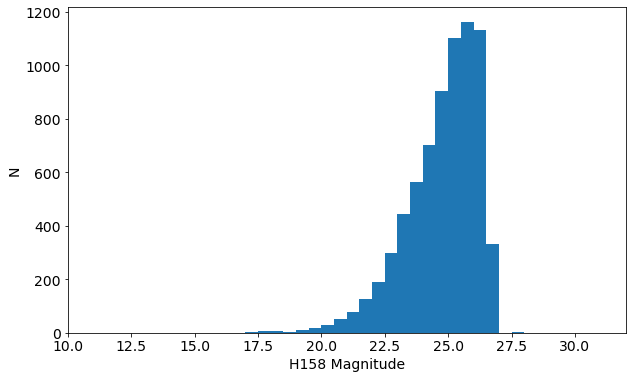

In [16]:
print(np.min(phot["MAG_AUTO"]),np.max(phot["MAG_AUTO"]))

fig = plt.figure()
p = fig.add_subplot(111)
p.hist(phot["MAG_AUTO"],range=(10,32),bins=44)
p.set_xlabel("H158 Magnitude")
p.set_ylabel("N")
p.set_xlim(10,32)

## (TESTING) Reload Core Grizli Python Functions - SKIP

Only use if you are editing the Python code while running the Jupyter notebook.

In [ ]:
import importlib
importlib.reload(grizli.model)

In [ ]:
import importlib
importlib.reload(grizli.grismconf)

In [ ]:
import importlib
importlib.reload(grizli.pipeline.auto_script)

## (TESTING) Fake segmentation image - SKIP

In [ ]:
# create fake segmentation

yl, xl = 4088, 4088
#seg = np.zeros((yl, xl))

id = 6572
#r0, d0 = 53.2356312, -27.8250528 # emission line object?
x0, y0 = 1208.681132551118, 1574.86233818024
r = 45 # pixels

seg_img = create_circular_mask(yl,xl,[x0,y0],r)*id
print(seg_img)

seg = "seg.fits"
hdu = pyfits.PrimaryHDU(seg_img,header=head)
#hdu.verify('warn')''
hdu.writeto(seg,clobber=True)

In [ ]:
# display segmentation
ext = 0
pf = pyfits.open(seg)
seg_img = pf[ext].data


fig = plt.figure()
p1 = fig.add_subplot(111)
p1.imshow(seg_img)

In [ ]:
phot = phot[phot["NUMBER"] == id]
print(phot)

## Roman object simulation

In [19]:
### Roman GRS grism
# allow simulation of objects at the edges
#pad=0 # pixels
pad = 800 # I think this may be optimal given the spectra size (only seems to add 10-20 spectra)

# using the ZP Anihita gave me for the direct image

# sims              old  new 
#mag_limit = 18 #    34   11
#mag_limit = 20 #   273   49
#mag_limit = 22 #  1599  334 
mag_limit = 24 #  5177 1830
#mag_limit = 26 # 10015 5704
#mag_limit = 28 #       7172

#h, wcs = grizli.fake_image.wfirst_header(ra=ra, dec=dec, pa_aper=pa_aper, naxis=(2048,2048))
#grizli.fake_image.make_fake_image(h, output='wfirst.fits', exptime=EXPTIME, nexp=NEXP)

Roman = grizli.model.GrismFLT(grism_file=new_slitless, verbose=True, pad=pad,  
                              ref_file=new_direct, ref_ext=1,
                              seg_file=seg, shrink_segimage=True)

Roman_cat = Roman.blot_catalog(phot, sextractor=True) 
Roman.catalog = Roman_cat

mask = Roman_cat['MAG_AUTO'] < mag_limit
print('N=%d' %(mask.sum()))
#Roman.compute_full_model(compute_beams=['A'], mask=mask, verbose=False)
Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask])
#Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask], verbose=True)

Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
GRS_FOV1_roll0_dx0_dy0_SCA1_slitless_GLW.fits / blot reference GRS_FOV1_roll0_dx0_dy0_SCA1_direct_GLW.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
GRS_FOV1_roll0_dx0_dy0_SCA1_slitless_GLW.fits / Pad ref HDU with 1650 pixels
GRS_FOV1_roll0_dx0_dy0_SCA1_slitless_GLW.fits / blot segmentation GRS_FOV1_roll0_dx0_dy0_SCA1_direct_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...
N=1830


## (TESTING) Roman pad and magnitude test - SKIP

In [ ]:
### Roman GRS grism

# test set
#pads = [0]
#mag_limits = [18,20]

pads = [0,100,200,400,800]
mag_limits = [18,20,22,24,26]

info_list = []
cat_list = []
i = 0 # iter
N = len(pads) * len(mag_limits) # total iter

for pad in pads:
    for mag_limit in mag_limits:

        Roman = grizli.model.GrismFLT(grism_file=new_slitless, verbose=True, pad=pad,  
                                      ref_file=new_direct, ref_ext=1,
                                      seg_file=seg, shrink_segimage=True)

        Roman_cat = Roman.blot_catalog(phot, sextractor=True) 
        Roman.catalog = Roman_cat

        mask = Roman_cat['MAG_AUTO'] < mag_limit
        Ntot = mask.sum()
        
        Roman.compute_full_model(ids=Roman_cat['NUMBER'][mask], mags=Roman_cat['MAG_AUTO'][mask])
        
        ids_ext = []
        for id in Roman.object_dispersers:
            is_cgs, spectrum_1d, beam = Roman.object_dispersers[id]
            if len(beam) > 0: 
                ids_ext.append(id)
        
        ids_ext = np.array(ids_ext)
        Next = len(ids_ext)
        
        print()
        print('iter = %i of %i' % (i+1,N))
        print('%5s %9s %5s %5s %9s' % ("pad", "mag_limit", "Ntot", "Next", "Next/Ntot"))
        print('%5d %9d %5d %5d %9.3f' % (pad, mag_limit, Ntot, Next, Next/Ntot))
        print("\n")
        
        info_list.append([pad, mag_limit, Ntot, Next])
        
        extract_cat = Roman.catalog[ids_ext - 1] 
        cat_list.append(extract_cat)
        
        fig = plt.figure(figsize=[20,10])
        # Direct
        ax1 = fig.add_subplot(121)
        ax1.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
                   origin='lower', vmin=-0.5, vmax=2.0, cmap='viridis')
        ax1.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
                   edgecolor='white', facecolor='none', alpha=0.7)
        ax1.set_xticklabels([])
        ax1.set_title('pad=%d  mag_limit=%d  Ntot=%d  Next=%d' %(pad,mag_limit,Ntot,Next))

        # Grism
        ax2 = fig.add_subplot(122)
        ax2.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
                   origin='lower', vmin=-0.5, vmax=2.0, cmap='gray_r')
        ax2.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
                   edgecolor='green', facecolor='none', alpha=0.7)
        ax2.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
        fig.tight_layout(pad=4.0)   
        
        i += 1
        
#print(info_list)


print("\n\n")
print("#"*12)
print("Test summary")
print("#"*12)
print('%5s %9s %5s %5s %9s' % ("pad", "mag_limit", "Ntot", "Next", "Next/Ntot"))
for info in info_list:
    pad, mag_limit, Ntot, Next = info
    print('%5d %9d %5d %5d %9.3f' % (pad, mag_limit, Ntot, Next, Next/Ntot))

print()
print(len(cat_list))
#print(cat_list)

## Check extractions

Possible problem with the aXeSIM conf file.  This function checks if the OrderDict exists within GrismFLT class.

In [20]:
all_cat,magcut_cat,extract_cat = check_sims(Roman, mag_limit)

All sources   = 7174
Magnitude cut = 1830
Simulated     = 569



In [21]:
Roman.catalog[:20].show_in_notebook()

idx,NUMBER,X_IMAGE,Y_IMAGE,X_WORLD,Y_WORLD,A_IMAGE,B_IMAGE,THETA_IMAGE,A_WORLD,B_WORLD,THETA_WORLD,FLUX_APER,FLUX_APER_1,FLUX_APER_2,FLUX_APER_3,FLUX_APER_4,FLUX_APER_5,FLUX_APER_6,FLUX_APER_7,FLUX_APER_8,FLUX_APER_9,FLUX_APER_10,FLUX_APER_11,FLUX_APER_12,FLUX_APER_13,FLUXERR_APER,FLUXERR_APER_1,FLUXERR_APER_2,FLUXERR_APER_3,FLUXERR_APER_4,FLUXERR_APER_5,FLUXERR_APER_6,FLUXERR_APER_7,FLUXERR_APER_8,FLUXERR_APER_9,FLUXERR_APER_10,FLUXERR_APER_11,FLUXERR_APER_12,FLUXERR_APER_13,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,MAG_BEST,MAGERR_BEST,KRON_RADIUS,PETRO_RADIUS,BACKGROUND,THRESHOLD,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,ERRA_WORLD,ERRB_WORLD,ERRTHETA_WORLD,XWIN_IMAGE,YWIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,THETAWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,MU_THRESHOLD,FLAGS,FWHM_IMAGE,FLUX_RADIUS,FLUX_RADIUS_1,CLASS_STAR,x_flt,y_flt,id,ra,dec
,,pix,pix,deg,deg,pix,pix,deg,deg,deg,deg,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,mag,mag,mag,mag,,,ct,ct,pix,pix,deg,deg,deg,deg,pix,pix,pix,pix,deg,pix,pix,deg,mag / arcsec2,,pix,pix,pix,,,,,deg,deg
0,1,3376.4963,73.9929,53.242008498,-27.806804338,2.036,1.478,-87.21,1.413582e-05,1.155242e-05,-34.28,4.751146,6.426812,6.877778,7.127317,7.668445,8.032232,8.183122,8.262062,8.650845,9.921555,14.10507,21.64993,47.35143,138.6724,2.190872,2.550728,2.643346,2.696637,2.803243,2.87649,2.912416,2.937025,3.014983,3.292414,3.964055,5.01975,7.557043,13.28599,8.34911,2.929961,25.6959,0.3811,25.577,0.3396,3.3,3.5,0.2437829,0.07277536,0.85422,0.61993,-87.18,5.929935e-06,4.846604e-06,-34.3,3376.4335,73.7584,0.868,0.712,56.78,0.64355,0.57468,55.87,23.1989,19,2.96,1.477,5.052,0.645,4176.496327541589,873.992909518119,1,53.242008498,-27.806804338
1,2,1422.2177,84.6252,53.228728843,-27.816813001,2.896,2.364,2.66,2.30181e-05,1.61372e-05,33.67,36.6485,66.12039,89.48715,103.9889,112.0233,115.7708,117.2668,117.7046,117.8718,117.9365,119.1413,123.8033,138.8387,219.7688,6.07648,8.162325,9.496462,10.23822,10.62801,10.80641,10.87851,10.90171,10.91274,10.9375,11.023,11.31819,12.22008,16.10645,118.1405,10.92647,22.819,0.1004,22.819,0.1004,3.3,3.96,0.2457868,0.07103519,0.27048,0.22068,2.66,2.149454e-06,1.506734e-06,33.67,1422.1938,84.6295,1.494,1.201,2.81,0.26057,0.2275,2.73,23.3327,0,4.97,2.287,4.333,0.91,2222.2177145461255,884.6251085042422,2,53.228728843,-27.816813001
2,3,3681.3301,85.169,53.244151638,-27.805304628,2.278,2.121,-73.85,1.71239e-05,1.530885e-05,19.49,9.273517,15.05925,18.90228,20.83202,21.6899,21.87439,22.14414,22.66054,23.26916,24.68326,27.01217,33.71696,52.6759,143.6611,3.058518,3.898758,4.370026,4.590685,4.688326,4.713369,4.748057,4.809255,4.879972,5.070762,5.359329,6.11334,7.907817,13.51225,22.72812,4.815646,24.6086,0.2301,24.6086,0.2301,3.4,3.5,0.2453906,0.07104921,0.51389,0.47848,-73.82,3.863087e-06,3.4539e-06,19.49,3681.2587,85.1111,1.214,1.04,-85.79,0.50047,0.45288,-86.42,23.2369,0,3.96,1.938,3.93,0.649,4481.33007616824,885.1689521504952,3,53.244151638,-27.805304628
3,4,2393.6538,79.2149,53.235329522,-27.811837436,2.116,1.933,21.22,1.680108e-05,1.322413e-05,26.21,14.46546,18.07818,18.83869,19.13945,19.37476,19.82254,20.41469,20.73617,21.22894,23.20634,27.53615,30.45588,48.58177,119.4086,3.818813,4.270935,4.362694,4.401143,4.432749,4.488853,4.56105,4.603469,4.664801,4.922205,5.408788,5.839677,7.64655,12.57932,20.48111,4.568637,24.7216,0.2422,24.7216,0.2422,3.3,3.5,0.2464089,0.07094557,0.4927,0.44995,21.21,3.912795e-06,3.078673e-06,26.22,2393.6058,79.1799,0.74,0.606,13.66,0.34682,0.30376,10.86,23.3462,18,2.19,1.204,2.74,0.645,3193.653919995661,879.2149974307746,4,53.235329522,-27.811837436
4,5,1731.0303,84.1768,53.230834346,-27.81523744,1.65,1.578,-88.52,1.271266e-05,1.110936e-05,19.06,3.981953,5.42217,6.232615,6.462623,6.636948,7.087885,7.249378,7.27534,7.461593,8.744821,9.174902,10.18689,22.77773,83.82314,2.006374,2.344161,2.517561,2.569799,2.611806,2.706561,2.746905,2.763409,2.810073,3.109228,3.281503,3.700982,5.700194,11.074,7.197503,2.7390

In [ ]:
#wcs = pywcs.WCS(head)

## Show direct images and slitless spectra (with padding)

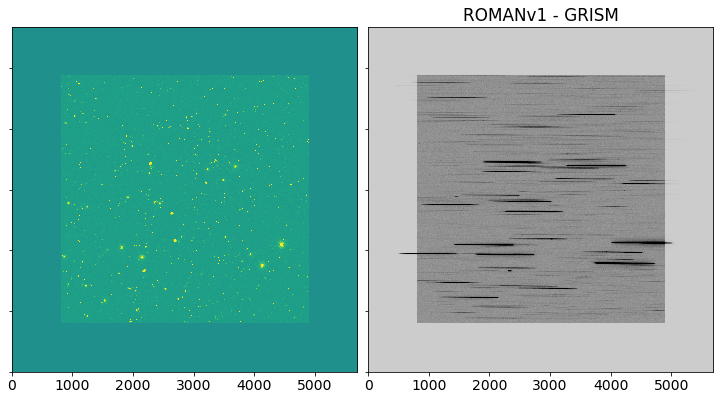

In [22]:
### Show them!

fig = plt.figure(figsize=[10,10.*2/3])
# Direct
axt = fig.add_subplot(121)
axt.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-2.0, vmax=2.0, cmap='viridis')
# Grism
axb = fig.add_subplot(122)
axb.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', cmap='gray_r', vmin=-0.5, vmax=2.0)
axb.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
    

axt.set_yticklabels([])
axb.set_yticklabels([])

fig.tight_layout(pad=0.5)

## Show direct images and slitless spectra (with sources overplotted)

This is a check to see if there is a field dependence (or magnitude) to the failed simulations.

(-0.5, 5687.5)
(-0.5, 5687.5)
(-0.5, 5687.5)
(-0.5, 5687.5)


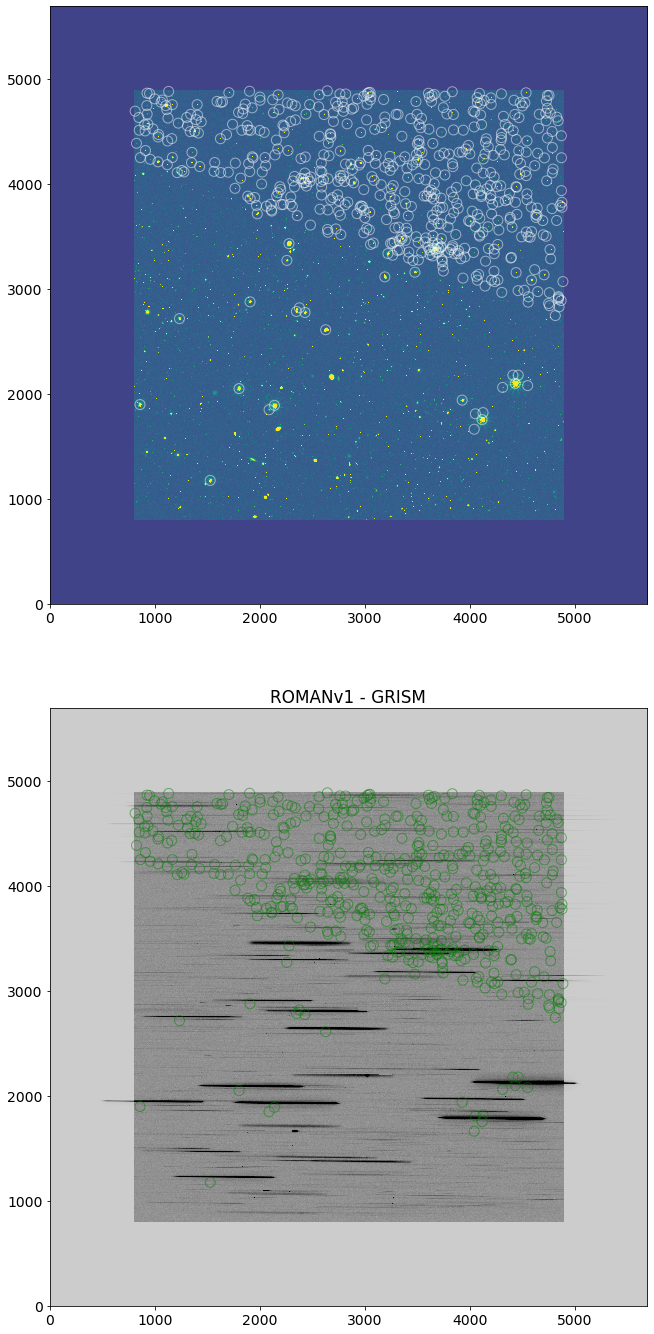

In [23]:
### Show them!
# Compare to the actual G141 exposure
fig = plt.figure(figsize=[10,20])

#extract_cat = Roman.catalog[0][0]

# Direct
#ax1 = fig.add_subplot(211, projection=wcs)
ax1 = fig.add_subplot(211)
ax1.imshow(Roman.direct.data['REF']/Roman.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-0.5, vmax=2.0, cmap='viridis')

#ax1.scatter(all_cat['ra'], all_cat['dec'], transform=ax1.get_transform('fk5'), s=100,
#           edgecolor='white', facecolor='none', alpha=0.5)
#ax1.scatter(magcut_cat['ra'], magcut_cat['dec'], transform=ax1.get_transform('fk5'), s=100,
#           edgecolor='white', facecolor='none', alpha=0.5)
#ax1.scatter(extract_cat['ra'], extract_cat['dec'], transform=ax1.get_transform('fk5'), s=200,
#           edgecolor='white', facecolor='none', alpha=0.5)

ax1.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
           edgecolor='white', facecolor='none', alpha=0.5)

#ax1.set_xlim(900,2900)
#ax1.set_ylim(1300,3300)

#ax1.set_xticklabels([])
print(ax1.get_xlim())
print(ax1.get_ylim())
    
# Grism
#ax2 = fig.add_subplot(212, projection=wcs)
ax2 = fig.add_subplot(212)
ax2.imshow(Roman.model + Roman.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', vmin=-0.5, vmax=2.0, cmap='gray_r')
#ax2.scatter(all_cat['ra'], all_cat['dec'], transform=ax2.get_transform('fk5'), s=100,
#           edgecolor='green', facecolor='none', alpha=0.5)
#ax2.scatter(magcut_cat['ra'], magcut_cat['dec'], transform=ax2.get_transform('fk5'), s=100,
#           edgecolor='green', facecolor='none', alpha=0.5)
#ax2.scatter(extract_cat['ra'], extract_cat['dec'], transform=ax2.get_transform('fk5'), s=100,
#           edgecolor='green', facecolor='none', alpha=0.5)

ax2.scatter(extract_cat['x_flt'], extract_cat['y_flt'], s=100,
           edgecolor='green', facecolor='none', alpha=0.5)


ax2.set_title('%s - %s' %(Roman.grism.instrument, Roman.grism.filter))
print(ax2.get_xlim())
print(ax2.get_ylim())

fig.tight_layout(pad=4.0)

In [24]:
print(phot.colnames)
print(phot["X_WORLD","Y_WORLD"])
print(phot["MAG_AUTO"])

['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'X_WORLD', 'Y_WORLD', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'A_WORLD', 'B_WORLD', 'THETA_WORLD', 'FLUX_APER', 'FLUX_APER_1', 'FLUX_APER_2', 'FLUX_APER_3', 'FLUX_APER_4', 'FLUX_APER_5', 'FLUX_APER_6', 'FLUX_APER_7', 'FLUX_APER_8', 'FLUX_APER_9', 'FLUX_APER_10', 'FLUX_APER_11', 'FLUX_APER_12', 'FLUX_APER_13', 'FLUXERR_APER', 'FLUXERR_APER_1', 'FLUXERR_APER_2', 'FLUXERR_APER_3', 'FLUXERR_APER_4', 'FLUXERR_APER_5', 'FLUXERR_APER_6', 'FLUXERR_APER_7', 'FLUXERR_APER_8', 'FLUXERR_APER_9', 'FLUXERR_APER_10', 'FLUXERR_APER_11', 'FLUXERR_APER_12', 'FLUXERR_APER_13', 'FLUX_AUTO', 'FLUXERR_AUTO', 'MAG_AUTO', 'MAGERR_AUTO', 'MAG_BEST', 'MAGERR_BEST', 'KRON_RADIUS', 'PETRO_RADIUS', 'BACKGROUND', 'THRESHOLD', 'ERRA_IMAGE', 'ERRB_IMAGE', 'ERRTHETA_IMAGE', 'ERRA_WORLD', 'ERRB_WORLD', 'ERRTHETA_WORLD', 'XWIN_IMAGE', 'YWIN_IMAGE', 'AWIN_IMAGE', 'BWIN_IMAGE', 'THETAWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ERRTHETAWIN_IMAGE', 'MU_THRESHOLD', 'FLAGS', 'FWHM_IMAGE', 'FLU

## (TESTING) Filter catalog based on position on the detector and magnitude - SKIP

In [ ]:
# OLD - DO NOT RUN!

cat = Roman.catalog
cat["NUMBER","MAG_AUTO","id","ra","dec","x_flt","y_flt"]
#cat.colnames

x_filt = (cat['x_flt'] > 2400) & (cat['x_flt'] < 2600)
y_filt = (cat['y_flt'] > 3900) & (cat['y_flt'] < 4100)
mag_filt = (cat['MAG_AUTO'] < 24)

filt = x_filt & y_filt & mag_filt

print(cat[filt]['MAG_AUTO','id',"ra","dec","x_flt","y_flt"])

## (TESTING) Reload Core Grizli Python Functions - SKIP

Only use if you are editing the Python code while running the Jupyter notebook.

In [18]:
from importlib import reload
reload(grizli.model)

<module 'grizli.model' from '/Users/gwalth/python/src/grizli_1.3.2/grizli/model.py'>

## Extract a single 2D spectrum (science, model and contamination) based on RA and Dec

ID:1367, mag=22.97
ROMANv1 2476.936121675804 4020.064434217118
(False, None, OrderedDict([('A', <grizli.model.GrismDisperser object at 0x7f9b202bb2b0>)]))
['MW_EBV', 'MW_F99', 'NX', 'PAM_value', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_to_full_image', 'add_ytrace_offset', 'beam', 'compute_model', 'compute_model_psf', 'conf', 'contained_in_full_array', 'cutout_from_full_image', 'direct', 'dx', 'dxfull', 'dxpix', 'flat_index', 'fwcpos', 'get_PAM_value', 'get_psf_sensitivity', 'grow', 'id', 'idx', 'init_extended_epsf', 'init_galactic_extinction', 'init_optimal_profile', 'is_cgs', 'lam', 'lam_beam', 'lam_sort', 'model', 'modelf', 'optimal_extract', 'origin', 'pad', 'process_config', 'ren

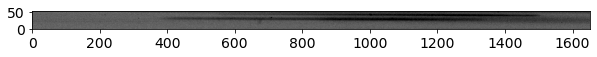

In [25]:
## Find the object ID near coordinates (r0,d0), 
## SExtractor IDs might not be constant across platforms
#r0, d0 = 53.234826075, -27.814092081
#r0, d0 = 53.236483671, -27.812812306

# GLW
#r0, d0 = 53.2411597, -27.8230357 # good! 5857
#r0, d0 = 53.2356312, -27.8250528 # emission line object? 6572
r0, d0 = 53.248050415, -27.830560455

dr = np.sqrt((phot['X_WORLD']-r0)**2*np.cos(d0/180*np.pi)**2 + 
             (phot['Y_WORLD']-d0)**2)*3600
id = phot['NUMBER'][np.argmin(dr)]
obj_mag = phot['MAG_AUTO'][np.argmin(dr)]
print('ID:%d, mag=%.2f' %(id, obj_mag))

beams = OrderedDict()


ix = Roman.catalog['id'] == id
x0, y0 = Roman.catalog['x_flt'][ix][0], Roman.catalog['y_flt'][ix][0]
print(Roman.direct.instrument, x0, y0)
#print(Roman.wcs.pscale)
#dim = 18*0.135/sim.flt_wcs.pscale 
#beam = grizli.model.BeamCutout(id=id, x=x0, y=y0, 
#                               cutout_dimensions=np.cast[int]((dim, dim)), 
#                               conf=sim.conf, GrismFLT=sim)

print(Roman.object_dispersers[id])

is_cgs, spectrum_1d, b = Roman.object_dispersers[id]
#print(b)

cutout = grizli.model.BeamCutout(Roman, b['A'], min_sens=0,) # min_mask=0) 

cutout.beam.compute_model()  
cutout.contam = cutout.beam.cutout_from_full_image(Roman.model)
if id in Roman.object_dispersers:
    cutout.contam -= cutout.beam.model

print(dir(cutout.beam))
#print(cutout.contam)
#print(cutout.beam.model)
#print(dir(cutout.beam))
print(cutout.beam.seg)
print(cutout.beam.seg.shape)

fig = plt.figure()
p1 = fig.add_subplot(311)
p1.imshow(cutout.grism.data['SCI']*1,vmin=-0.1,vmax=1.0, origin='lower',cmap='gray_r')
#p1.imshow(cutout.grism.data['ERR']*1)#,vmin=-0.1,vmax=0.1, origin='lower',cmap='gray_r')
    
beams[Roman.grism.instrument] = cutout

## aXeSIM predictions based on conf file

In [26]:
from grizli import grismconf

In [27]:
#conf = grismconf.load_grism_config("../../../grizli/CONF/Roman.det1.07242020.conf")
conf = grismconf.load_grism_config("../../../grizli/CONF/Roman_bad/Roman.det1.07242020.conf")
dx = conf.dxlam["A"]
print(dx)
dy,lam = conf.get_beam_trace(x=x0,y=y0,dx=dx)
print(dy)
print(lam)

[-800 -799 -798 ...  797  798  799]
[3.20396603 3.20241719 3.20086862 ... 1.07741105 1.07629698 1.07518318]
[24237.21827306 24226.38676848 24215.55523164 ...  6898.1901663
  6887.30713847  6876.42407837]


Beam A, lambda=(7258.5 - 24807.1)


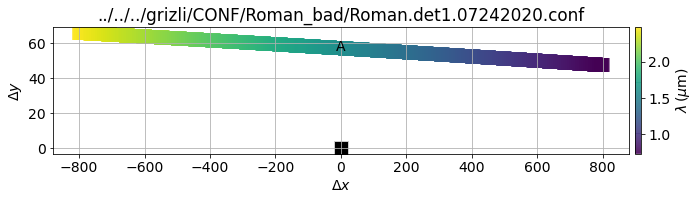

In [28]:
conf.show_beams()

In [29]:
print(os.getcwd())

/Users/gwalth/data/Roman/grizli/Roman/new_simulation/Prep


## Show 2D beam (data and contamination)

[[0.5667909  0.5788088  0.6193046  ... 0.52989703 0.6453369  0.6195575 ]
 [0.55254275 0.5684005  0.5677628  ... 0.635091   0.64024496 0.5659137 ]
 [0.5842378  0.56523895 0.5766706  ... 0.4903816  0.5530882  0.67757887]
 ...
 [0.57636535 0.59061795 0.61306036 ... 0.8490409  0.82606864 0.7839282 ]
 [0.58410174 0.6084411  0.5824161  ... 0.8173112  0.72809666 0.80844575]
 [0.6297046  0.61784285 0.6901748  ... 0.6836926  0.7391906  0.6819187 ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[2.5834441e-07 2.5832648e-07 2.5830849e-07 ... 3.3242922e-02
  3.3241723e-02 3.3240166e-02]
 [2.6421910e-07 2.6430627e-07 2.6439332e-07 ... 3.1229403e-02
  3.1215413e-02 3.1201366e-02]
 [2.9691097e-07 2.9676750e-07 2.9662399e-07 ... 2.8372450e-02
  2.8367996e-02 2.8363474e-02]
 ...
 [8.2825449e-07 8.2908230e-07 8.2990903e-07 ... 1.6334170e-01
  1.6307025e-01 1.6278657e-01]
 [1.1146894e-06 1.11523

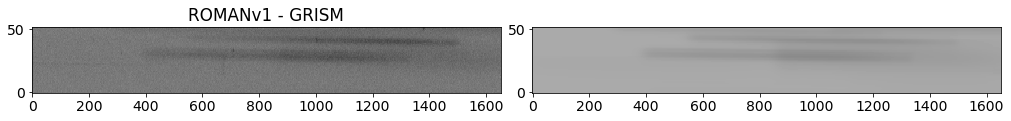

In [30]:
## Spectrum with lines & noise
#spectrum_file = os.path.join(os.path.dirname(grizli.__file__), 'data/erb2010.dat')
#spectrum_file = '../../../grizli/templates/erb2010.dat'
#erb = np.loadtxt(spectrum_file, unpack=True)
#z = 2.0 # test redshift

## normalize spectrum to unity to use normalization defined in the direct image
#import pysynphot as S
#spec = S.ArraySpectrum(erb[0], erb[1], fluxunits='flam')
#spec = spec.redshift(z).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f140w'))
#spec.convert('flam') # bug in pysynphot, now units being converted automatically above? (11/10/16)

fig = plt.figure(figsize=(14,4))
for i, key in enumerate(beams.keys()):
    #     beams[key].compute_model(beams[key].thumb, id=beams[key].id, 
    #                              xspec=spec.wave, yspec=spec.flux)
    #print(key)
    #beams[key].beam.compute_model(spectrum_1d=[spec.wave, spec.flux]) 
    #beams[key].beam.compute_model()
    
    gdata = beams[key].grism.data['SCI']*1
    gmodel = beams[key].model
    gcontam = beams[key].contam
    
    print(gdata)
    print(gmodel)
    print(gcontam)
    
    print(np.min(gdata),np.max(gdata))
    print(np.min(gmodel),np.max(gmodel))
    print(np.min(gcontam),np.max(gcontam))
    
    print(gdata.shape)
    print(gmodel.shape)
    print(gcontam.shape)
    
    axl = fig.add_subplot(321+i*2)
    #axl.imshow(beams[key].model + beams[key].grism.data['SCI']*1, interpolation='Nearest', 
    #       origin='lower', vmin=-0.006, vmax=0.16, cmap='gray_r', aspect='auto')
    
    axl.imshow(beams[key].grism.data['SCI']*1, interpolation='Nearest', 
           origin='lower', vmin=-1, vmax=2, cmap='gray_r', aspect='auto')
    
    
    axr = fig.add_subplot(321+i*2+1)
    #axr.imshow(beams[key].contam + beams[key].grism.data['SCI'] + beams[key].model, 
    #           interpolation='Nearest', 
    #           origin='lower', vmin=-1, vmax=2, cmap='gray_r', aspect='auto')

    axr.imshow(beams[key].contam , 
               interpolation='Nearest', 
               origin='lower', vmin=-1, vmax=2, cmap='gray_r', aspect='auto')
    
    axl.set_title('%s - %s' %(key, beams[key].grism.filter))
    #for ax in [axl, axr]:
    #    beams[key].beam.twod_axis_labels(wscale=1.e4, mpl_axis=ax)
    #    beams[key].beam.twod_xlim(1.3,1.75, wscale=1.e4, mpl_axis=ax)
    #    if i < 2:
    #        ax.set_xticklabels([])
    #    else:
    #        ax.set_xlabel(r'$\lambda$')

fig.tight_layout(pad=0.5)

In [31]:
# determine flux in Ang for the source in the direct image
c = 2.9979E10 # cm/s
Ang = 1E-8    # cm
Jy = 1E-23    # erg/s/cm^2/Hz

mab = phot[phot['NUMBER']==id]['MAG_AUTO'][0]
eff_wav = 15800.

# mab = -2.5*np.log10(fnu) - 48.6 
fnu = 10**(-0.4*(mab + 48.6))          # erg/s/cm^2/Hz
flambda = fnu*(c/(eff_wav*Ang)**2)*Ang # erg/s/cm^2/Ang
f_scale = flambda
print("%.2e erg/s/cm^2/Hz" % (fnu))
print("%.2e Jy" % (fnu/Jy))
print("%.4f uJy" % (fnu/(1e-6*Jy)))
print("%.1f nJy" % (fnu/(1e-9*Jy)))
print()
print("%.2e erg/s/cm^2/Ang" % (flambda))

2.35e-29 erg/s/cm^2/Hz
2.35e-06 Jy
2.3535 uJy
2353.5 nJy

2.83e-19 erg/s/cm^2/Ang


## 1D Spectral Extraction

ROMANv1
1.3514896e-19 4.1210278e-19
Size = 1652
NaNs =  36


Text(0, 0.5, 'F$_{\\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$]')

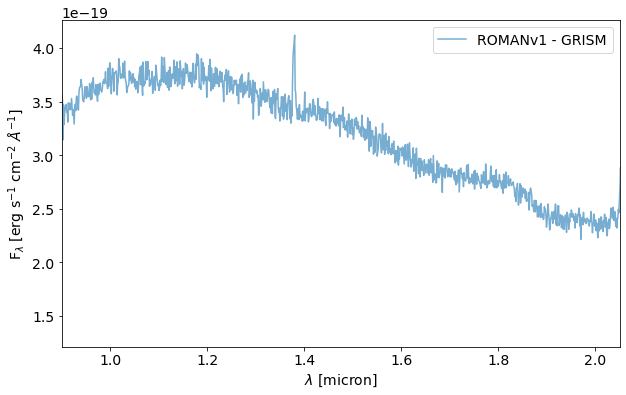

In [32]:
### Plot 1D spectra
fig = plt.figure()
p = fig.add_subplot(111)
for i, key in enumerate(beams.keys()):
    print(key)
    #w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    w, f, e = beams[key].beam.optimal_extract(beams[key].grism.data['SCI'], bin=0)
    
    # normalize to the magnitude in the direct image
    f = f/np.nanmedian(f) * f_scale
    
    p.plot(w/1.e4, f, label='%s - %s' %(key, beams[key].grism.filter), 
             alpha=0.6,) # linestyle='steps-mid')
    #print(f)
    
    y0 = np.nanmin(f)
    y1 = np.nanmax(f)
    print(y0,y1)
    
    #z = 1.726
    #lines = [4861.,5007.,6563.]
    #for line in lines:
    #    wobs = line/1e4*(1+z)
    #    p.plot([wobs,wobs],[y0,y1],"--",c="r")
    
    print("Size =", len(f))
    print("NaNs = ", np.sum(np.isnan(f)))
    #print(np.nanmedian(f))

p.legend(fontsize=14)
p.set_xlim(0.9, 2.05)
p.set_xlabel(r'$\lambda$ [micron]')
p.set_ylabel(r'F$_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')